# PROJECT 2
## Using a similairty matrix (2 different ways!) 

### Imports and global varialbes

In [38]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import entropy

# Global variables
TIME_LIMIT = 3600  
# PUT YOUR FILE PATHS HERE!!!
TRAINING_DATA_FILE = '2023data.csv'
TESTING_DATA_FILE = '2024data.csv'
# Number of bins for KL Divergence calculation. We chose to use 100
NUM_BINS = 100  
# Number of parts to divide n into for m values (10 for most of this project)
NUM_PARTS = 10  


### Load and preprocess data

In [40]:
# Load 2023 stock price data and NASDAQ index price (training set)
stock_data_2023 = pd.read_csv(TRAINING_DATA_FILE)
stock_data_2023.set_index(stock_data_2023.columns[0], inplace=True)

# Extract NASDAQ index price and stock prices
ndx_price_2023 = stock_data_2023.iloc[:, 0]
stock_prices_2023 = stock_data_2023.iloc[:, 1:]

# Handle missing data in stock prices using interpolation and then backward and forward filling if needed
stock_prices_2023_interpolated = stock_prices_2023.interpolate(method='linear', limit_direction='both')
if stock_prices_2023_interpolated.isnull().values.any():
    stock_prices_2023_interpolated = stock_prices_2023_interpolated.fillna(method='ffill').fillna(method='bfill')

# Calculate daily returns for stocks and index
returns_2023 = stock_prices_2023_interpolated.pct_change().dropna()
index_returns_2023 = ndx_price_2023.pct_change().dropna()

# Align dates between stock returns and index returns
returns_2023 = returns_2023.loc[index_returns_2023.index]
index_returns_2023 = index_returns_2023.loc[returns_2023.index]

# Extract list of stock names and number of stocks
stocks = returns_2023.columns.tolist()
n = len(stocks)

# Do all the same for 2024/testing set!
stock_data_2024 = pd.read_csv(TESTING_DATA_FILE)
stock_data_2024.set_index(stock_data_2024.columns[0], inplace=True)

ndx_price_2024 = stock_data_2024.iloc[:, 0]
stock_prices_2024 = stock_data_2024.iloc[:, 1:]

stock_prices_2024_interpolated = stock_prices_2024.interpolate(method='linear', limit_direction='both')
if stock_prices_2024_interpolated.isnull().values.any():
    stock_prices_2024_interpolated = stock_prices_2024_interpolated.fillna(method='ffill').fillna(method='bfill')

returns_2024 = stock_prices_2024_interpolated.pct_change().dropna()
index_returns_2024 = ndx_price_2024.pct_change().dropna()

returns_2024 = returns_2024.loc[index_returns_2024.index]
index_returns_2024 = index_returns_2024.loc[returns_2024.index]




### KL Divergence Similairty Matrix

In [42]:
# Create the bins for probability distributions
min_return = returns_2023.values.min()
max_return = returns_2023.values.max()
bins = np.linspace(min_return, max_return, NUM_BINS + 1)

# Compute probability distributions for each stock's returns
prob_distributions = []
for stock in stocks:
    hist, _ = np.histogram(returns_2023[stock], bins=bins, density=False)
    # Avoids zero probabilities by doing this
    hist = hist + 1e-10  
    prob_dist = hist / hist.sum()
    prob_distributions.append(prob_dist)

# Compute symmetric KL Divergence matrix
kl_divergence_matrix = np.zeros((n, n))
for i in range(n):
    P_i = prob_distributions[i]
    for j in range(n):
        P_j = prob_distributions[j]
        D_ij = entropy(P_i, P_j)
        D_ji = entropy(P_j, P_i)
        D_sym = (D_ij + D_ji) / 2
        kl_divergence_matrix[i, j] = D_sym

# Convert KL divergence to similarity measure
similarity_matrix_kld = 1 / (1 + kl_divergence_matrix)
# Similarity matrix using KL Divergence
rho_kld = similarity_matrix_kld  

### Correlation Similairty Matrix

In [44]:
# Compute Pearson correlation matrix
rho_df = returns_2023.corr()
# Similarity matrix using correlation
rho_corr = rho_df.values  


### Optimizing (Linear and Integer) 
#### All stock selction and weight info is printed at the end of this block

In [46]:
# Generate m values to test
m_values = [5] + [int(n * (i + 1) / NUM_PARTS) for i in range(NUM_PARTS)]
# extra precaution!
m_values = sorted(set(m_values))

# do our integer and then linear optimization described in problem documenation 
def run_optimization(rho, method_name):
    results = []
    for m in m_values:
    
        model = Model()
        y = model.addVars(n, vtype=GRB.BINARY)
        x = model.addVars(n, n, vtype=GRB.BINARY)

        # Objective Function (selcting stocks - integer)
        model.setObjective(quicksum(rho[i][j] * x[i, j] for i in range(n) for j in range(n)), GRB.MAXIMIZE)

        # add our constraints 
        model.addConstr(quicksum(y[j] for j in range(n)) == m)
        model.addConstrs((quicksum(x[i, j] for j in range(n)) == 1 for i in range(n)))
        model.addConstrs((x[i, j] <= y[j] for i in range(n) for j in range(n)))

        model.Params.OutputFlag = 0  
        model.optimize()

        selected_stocks_indices = [j for j in range(n) if y[j].X > 0.5]
        selected_stocks = [stocks[j] for j in selected_stocks_indices]

        # Prepare data for the linear model
        returns_2023_selected = returns_2023[selected_stocks].dropna()
        index_returns_2023_selected = index_returns_2023.loc[returns_2023_selected.index]
        returns_2024_selected = returns_2024[selected_stocks].dropna()
        index_returns_2024_selected = index_returns_2024.loc[returns_2024_selected.index]

        m_selected = len(selected_stocks)
        T_2023 = len(returns_2023_selected)

        # Portfolio Weight Optimization Model (the linear part)
        model_lp = Model()
        w = model_lp.addVars(m_selected, lb=0, ub=1)
        y_lp = model_lp.addVars(T_2023, lb=0)

        # add our constraints
        model_lp.addConstr(quicksum(w[i] for i in range(m_selected)) == 1)
        r_it = returns_2023_selected.values
        q_t = index_returns_2023_selected.values

        model_lp.addConstrs(
            (y_lp[t] >= q_t[t] - quicksum(w[i] * r_it[t, i] for i in range(m_selected)) for t in range(T_2023))
        )
        model_lp.addConstrs(
            (y_lp[t] >= quicksum(w[i] * r_it[t, i] for i in range(m_selected)) - q_t[t] for t in range(T_2023))
        )

        # Objective Function (don't need to add minmize but it makes more sense if you read it) 
        model_lp.setObjective(quicksum(y_lp[t] for t in range(T_2023)), GRB.MINIMIZE)

        # Solve the LP model
        model_lp.Params.OutputFlag = 0
        model_lp.optimize()

        # Get our optimal weights 
        if model_lp.Status == GRB.OPTIMAL:
            optimal_weights = [w[i].X for i in range(m_selected)]
        else:
            print(f"Optimization unsuccessful for m={m} using {method_name}.")
            continue

        # Evaluate our performance
        # @ is matrix multplication. went over it some in class
        portfolio_returns_2023 = returns_2023_selected.values @ np.array(optimal_weights)
        portfolio_returns_2024 = returns_2024_selected.values @ np.array(optimal_weights)
        tracking_error_2023 = np.sum(np.abs(portfolio_returns_2023 - index_returns_2023_selected.values))
        tracking_error_2024 = np.sum(np.abs(portfolio_returns_2024 - index_returns_2024_selected.values))

        # Store our results
        results.append({
            "m": m,
            "selected_stocks": selected_stocks,
            "optimal_weights": optimal_weights,
            "tracking_error_2023": tracking_error_2023,
            "tracking_error_2024": tracking_error_2024
        })

        print(f"\nResults for m = {m} using {method_name}:")
        print(f"Selected stocks: {selected_stocks}")
        print(f"Optimal weights: {optimal_weights}")
        print(f"In-Sample Tracking Error (2023): {tracking_error_2023:.6f}")
        print(f"Out-of-Sample Tracking Error (2024): {tracking_error_2024:.6f}")
    return results

# Run optimization using KL Divergence similarity matrix
results_kld = run_optimization(rho_kld, method_name="KL Divergence")

# Run optimization using Correlation similarity matrix
results_corr = run_optimization(rho_corr, method_name="Correlation")




Results for m = 5 using KL Divergence:
Selected stocks: ['AMAT', 'CCEP', 'CSX', 'MRVL', 'MSFT']
Optimal weights: [0.16492880626130277, 0.18988479176450804, 0.14787164780682635, 0.057380419854871086, 0.4399343343124918]
In-Sample Tracking Error (2023): 0.991490
Out-of-Sample Tracking Error (2024): 0.709610

Results for m = 10 using KL Divergence:
Selected stocks: ['AMD', 'AMAT', 'ARM', 'TEAM', 'BKR', 'CCEP', 'CSX', 'MAR', 'MRVL', 'MSFT']
Optimal weights: [0.040184227938731054, 0.10039432753480966, 0.03194617141786081, 0.057844891418369446, 0.05368052270015809, 0.16611017258730806, 0.07622472735240605, 0.0637180877814214, 0.029066986947264072, 0.38082988432167136]
In-Sample Tracking Error (2023): 0.853678
Out-of-Sample Tracking Error (2024): 0.648564

Results for m = 20 using KL Divergence:
Selected stocks: ['AMD', 'AMAT', 'ARM', 'TEAM', 'BKR', 'CRWD', 'CSX', 'DDOG', 'EA', 'KHC', 'LRCX', 'MAR', 'MRVL', 'MSFT', 'MDB', 'ORLY', 'QCOM', 'SMCI', 'TMUS', 'WBD']
Optimal weights: [0.03351374291

### Plotting Tracking Errors

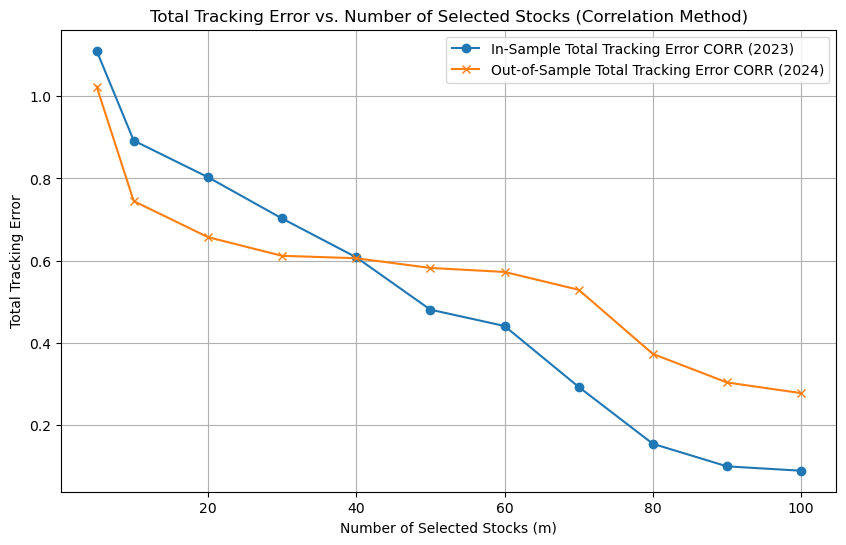

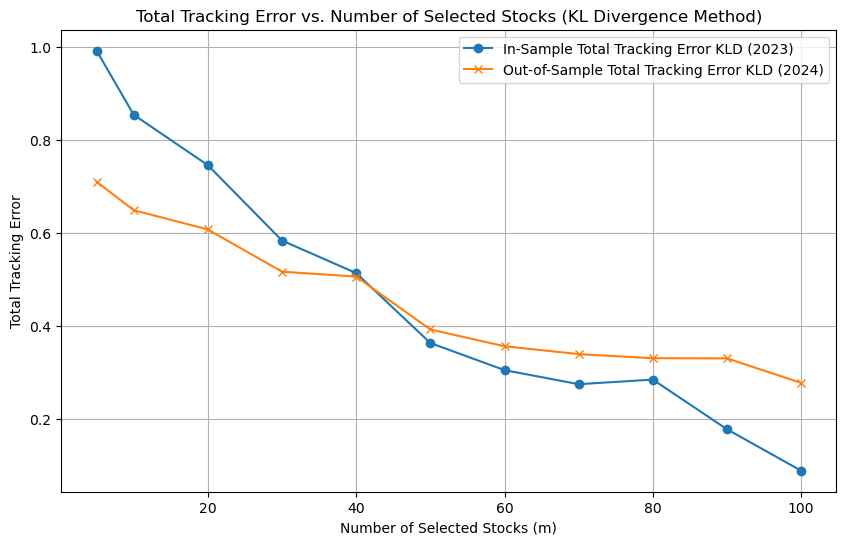

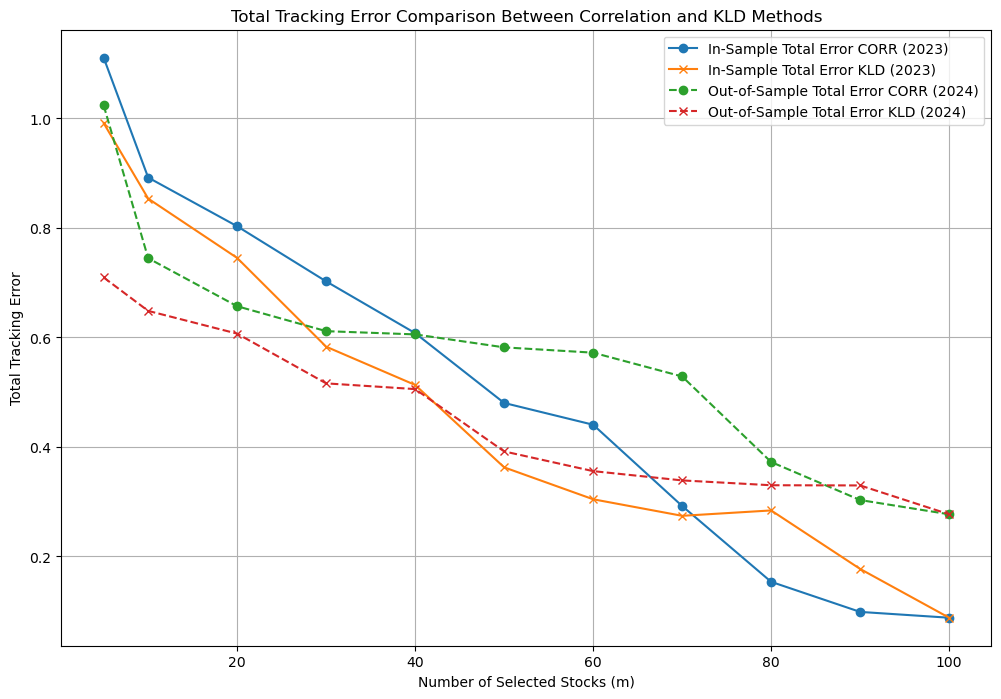

In [48]:
# Extract tracking errors for plotting
tracking_errors_2023_corr = [result["tracking_error_2023"] for result in results_corr]
tracking_errors_2024_corr = [result["tracking_error_2024"] for result in results_corr]
m_values_corr = [result["m"] for result in results_corr]

tracking_errors_2023_kld = [result["tracking_error_2023"] for result in results_kld]
tracking_errors_2024_kld = [result["tracking_error_2024"] for result in results_kld]
m_values_kld = [result["m"] for result in results_kld]

# Plot 1: Tracking Errors for Correlation Method
plt.figure(figsize=(10, 6))
plt.plot(m_values_corr, tracking_errors_2023_corr, label="In-Sample Total Tracking Error CORR (2023)", marker='o')
plt.plot(m_values_corr, tracking_errors_2024_corr, label="Out-of-Sample Total Tracking Error CORR (2024)", marker='x')
plt.xlabel("Number of Selected Stocks (m)")
plt.ylabel("Total Tracking Error")
plt.title("Total Tracking Error vs. Number of Selected Stocks (Correlation Method)")
plt.legend()
plt.grid(True)

# Plot 2: Tracking Errors for KL Divergence Method
plt.figure(figsize=(10, 6))
plt.plot(m_values_kld, tracking_errors_2023_kld, label="In-Sample Total Tracking Error KLD (2023)", marker='o')
plt.plot(m_values_kld, tracking_errors_2024_kld, label="Out-of-Sample Total Tracking Error KLD (2024)", marker='x')
plt.xlabel("Number of Selected Stocks (m)")
plt.ylabel("Total Tracking Error")
plt.title("Total Tracking Error vs. Number of Selected Stocks (KL Divergence Method)")
plt.legend()
plt.grid(True)

# Plot 3: Tracking Error Comparison Between Correlation and KLD Methods
plt.figure(figsize=(12, 8))
plt.plot(m_values_corr, tracking_errors_2023_corr, label="In-Sample Total Error CORR (2023)", marker='o')
plt.plot(m_values_kld, tracking_errors_2023_kld, label="In-Sample Total Error KLD (2023)", marker='x')
plt.plot(m_values_corr, tracking_errors_2024_corr, label="Out-of-Sample Total Error CORR (2024)", marker='o', linestyle='--')
plt.plot(m_values_kld, tracking_errors_2024_kld, label="Out-of-Sample Total Error KLD (2024)", marker='x', linestyle='--')
plt.xlabel("Number of Selected Stocks (m)")
plt.ylabel("Total Tracking Error")
plt.title("Total Tracking Error Comparison Between Correlation and KLD Methods")
plt.legend()
plt.grid(True)


# MIP CODE

In [16]:
# run our much longer MIP solution to the problem 

def run_mip_optimization(m_values, time_limit):
    results_mip = []
    for m in m_values:
        mip_model = Model()
        mip_model.Params.TimeLimit = time_limit
        mip_model.Params.OutputFlag = 0  

        # add our varaibles one by one so I can understand what I am doing
        w = mip_model.addVars(n, vtype=GRB.CONTINUOUS, lb=0.0)
        y = mip_model.addVars(n, vtype=GRB.BINARY)
        z = mip_model.addVars(len(index_returns_2023), vtype=GRB.CONTINUOUS, lb=0.0)

        mip_model.setObjective(quicksum(z[t] for t in range(len(index_returns_2023))), GRB.MINIMIZE)

        # add our constraints
        # Linking weights to selection variables
        # Since weights sum to 1 and are non-negative, we get a BIG M of 1
        M = 1.0  
        mip_model.addConstrs((w[i] <= M * y[i] for i in range(n)))
        mip_model.addConstr(quicksum(y[i] for i in range(n)) == m)
        mip_model.addConstr(quicksum(w[i] for i in range(n)) == 1)

        # get our absolute deviations
        for t in range(len(index_returns_2023)):
            portfolio_return = quicksum(w[i] * returns_2023.iloc[t, i] for i in range(n))
            index_return = index_returns_2023.iloc[t]
            mip_model.addConstr(z[t] >= index_return - portfolio_return)
            mip_model.addConstr(z[t] >= portfolio_return - index_return)

        mip_model.optimize()

        # retrieve our results
        if mip_model.Status in [GRB.OPTIMAL, GRB.TIME_LIMIT]:
            selected_stocks_indices = [i for i in range(n) if y[i].X > 0.5]
            selected_stocks = [stocks[i] for i in selected_stocks_indices]
            weights = {stocks[i]: w[i].X for i in selected_stocks_indices}

            # Evaluate performance
            # For 2023
            portfolio_returns_2023 = returns_2023[selected_stocks] @ np.array([weights[stock] for stock in selected_stocks])
            index_returns_2023_selected = index_returns_2023.loc[portfolio_returns_2023.index]

            tracking_error_2023 = np.sum(np.abs(portfolio_returns_2023 - index_returns_2023_selected))

            # For 2024
            # Ensure selected stocks are in 2024 data
            missing_stocks_2024 = set(selected_stocks) - set(returns_2024.columns)
            if missing_stocks_2024:
                print(f"Warning: Stocks missing in 2024 data for m={m}: {missing_stocks_2024}")
                # Remove missing stocks from weights and normalize
                for stock in missing_stocks_2024:
                    del weights[stock]
                selected_stocks = [stock for stock in selected_stocks if stock in returns_2024.columns]
                total_weight = sum(weights.values())
                weights = {stock: weight / total_weight for stock, weight in weights.items()}

            portfolio_returns_2024 = returns_2024[selected_stocks] @ np.array([weights[stock] for stock in selected_stocks])
            index_returns_2024_selected = index_returns_2024.loc[portfolio_returns_2024.index]

            tracking_error_2024 = np.sum(np.abs(portfolio_returns_2024 - index_returns_2024_selected))

            # Store the results
            results_mip.append({
                "m": m,
                "selected_stocks": selected_stocks,
                "weights": weights,
                "tracking_error_2023": tracking_error_2023,
                "tracking_error_2024": tracking_error_2024
            })

            print(f"\nMIP Results for m = {m}:")
            print(f"Selected stocks: {selected_stocks}")
            print(f"Weights: {[weights[stock] for stock in selected_stocks]}")
            print(f"In-Sample Tracking Error (2023): {tracking_error_2023:.6f}")
            print(f"Out-of-Sample Tracking Error (2024): {tracking_error_2024:.6f}")
        else:
            print(f"MIP Optimization unsuccessful for m={m}.")
    return results_mip

# Run MIP optimization
results_mip = run_mip_optimization(m_values, TIME_LIMIT)


Set parameter TimeLimit to value 3600

MIP Results for m = 10:
Selected stocks: ['GOOGL', 'AMZN', 'AAPL', 'CHTR', 'EA', 'MCHP', 'MSFT', 'MDLZ', 'NVDA', 'TSLA']
Weights: [0.08738711496327603, 0.13406891767072904, 0.17464053236531737, 0.04968076375920088, 0.08358320369916658, 0.09489651971367637, 0.134770189429597, 0.11765031890779533, 0.07851300786764553, 0.04480943162359577]
In-Sample Tracking Error (2023): 0.359938
Out-of-Sample Tracking Error (2024): 0.588651
Set parameter TimeLimit to value 3600

MIP Results for m = 20:
Selected stocks: ['ADBE', 'AMD', 'GOOGL', 'AMZN', 'ADI', 'AAPL', 'AMAT', 'ADP', 'BKR', 'AVGO', 'CMCSA', 'META', 'MSFT', 'MRNA', 'NFLX', 'NVDA', 'PEP', 'ROST', 'TMUS', 'TSLA']
Weights: [0.029611669729066217, 0.021459020831834593, 0.06476428872810201, 0.07156662669909573, 0.047729428254779896, 0.10547150989441381, 0.04119851303974289, 0.06308345356112538, 0.029482924202024675, 0.03931454573103147, 0.029238617510409508, 0.03303335433214113, 0.15033508043692126, 0.013878

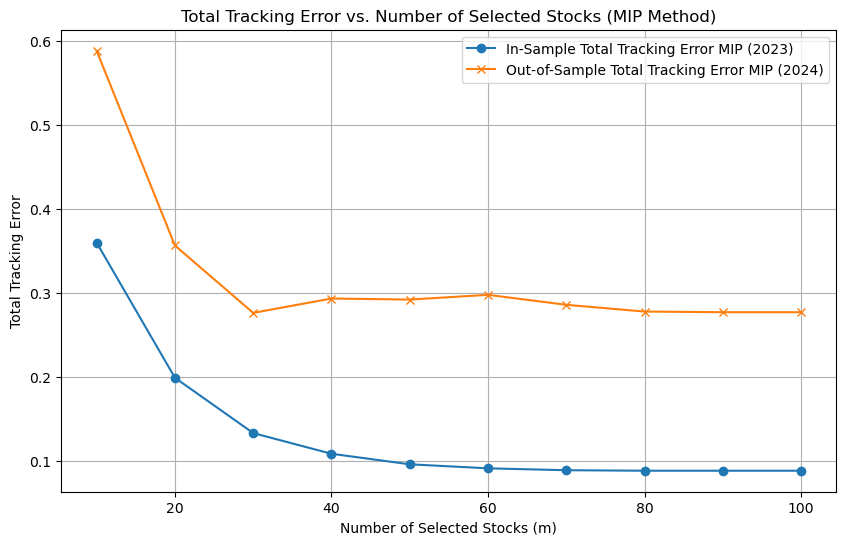

In [17]:
# Extract tracking errors for MIP method
tracking_errors_2023_mip = [result["tracking_error_2023"] for result in results_mip]
tracking_errors_2024_mip = [result["tracking_error_2024"] for result in results_mip]
m_values_mip = [result["m"] for result in results_mip]

# Plot tracking errors for MIP method
plt.figure(figsize=(10, 6))
plt.plot(m_values_mip, tracking_errors_2023_mip, label="In-Sample Total Tracking Error MIP (2023)", marker='o')
plt.plot(m_values_mip, tracking_errors_2024_mip, label="Out-of-Sample Total Tracking Error MIP (2024)", marker='x')
plt.xlabel("Number of Selected Stocks (m)")
plt.ylabel("Total Tracking Error")
plt.title("Total Tracking Error vs. Number of Selected Stocks (MIP Method)")
plt.legend()
plt.grid(True)


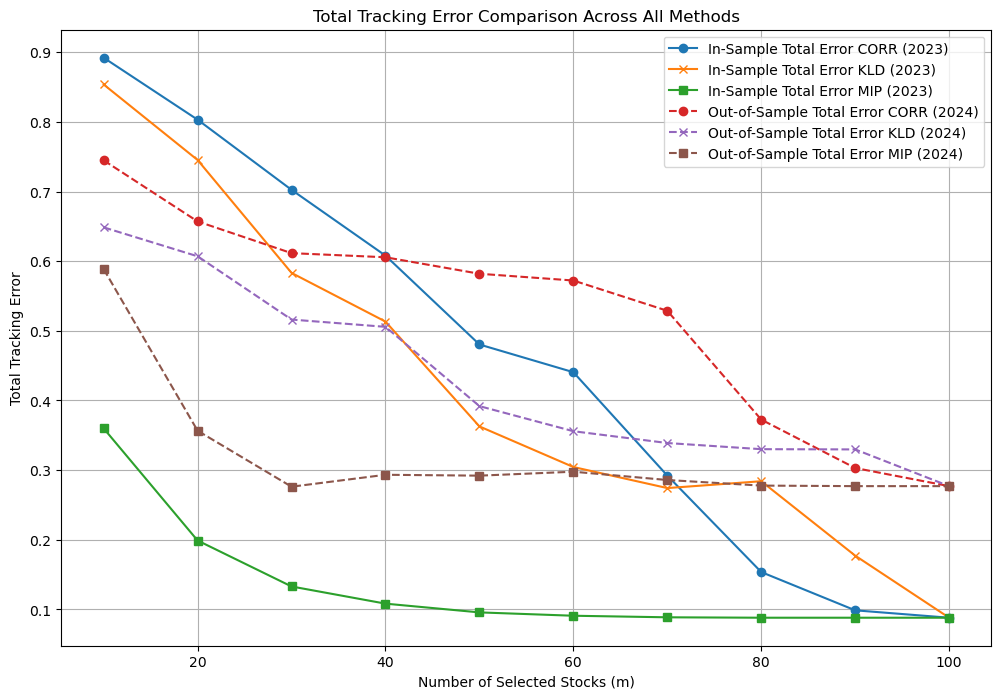

In [18]:
# Plot tracking errors for all three methods
plt.figure(figsize=(12, 8))

# In-Sample Tracking Error
plt.plot(m_values_corr, tracking_errors_2023_corr, label="In-Sample Error CORR (2023)", marker='o')
plt.plot(m_values_kld, tracking_errors_2023_kld, label="In-Sample Error KLD (2023)", marker='x')
plt.plot(m_values_mip, tracking_errors_2023_mip, label="In-Sample Error MIP (2023)", marker='s')

# Out-of-Sample Tracking Error
plt.plot(m_values_corr, tracking_errors_2024_corr, label="Out-of-Sample Error CORR (2024)", marker='o', linestyle='--')
plt.plot(m_values_kld, tracking_errors_2024_kld, label="Out-of-Sample Error KLD (2024)", marker='x', linestyle='--')
plt.plot(m_values_mip, tracking_errors_2024_mip, label="Out-of-Sample Error MIP (2024)", marker='s', linestyle='--')

plt.xlabel("Number of Selected Stocks (m)")
plt.ylabel("Tracking Error")
plt.title("Tracking Error Comparison Across All Methods")
plt.legend()
plt.grid(True)


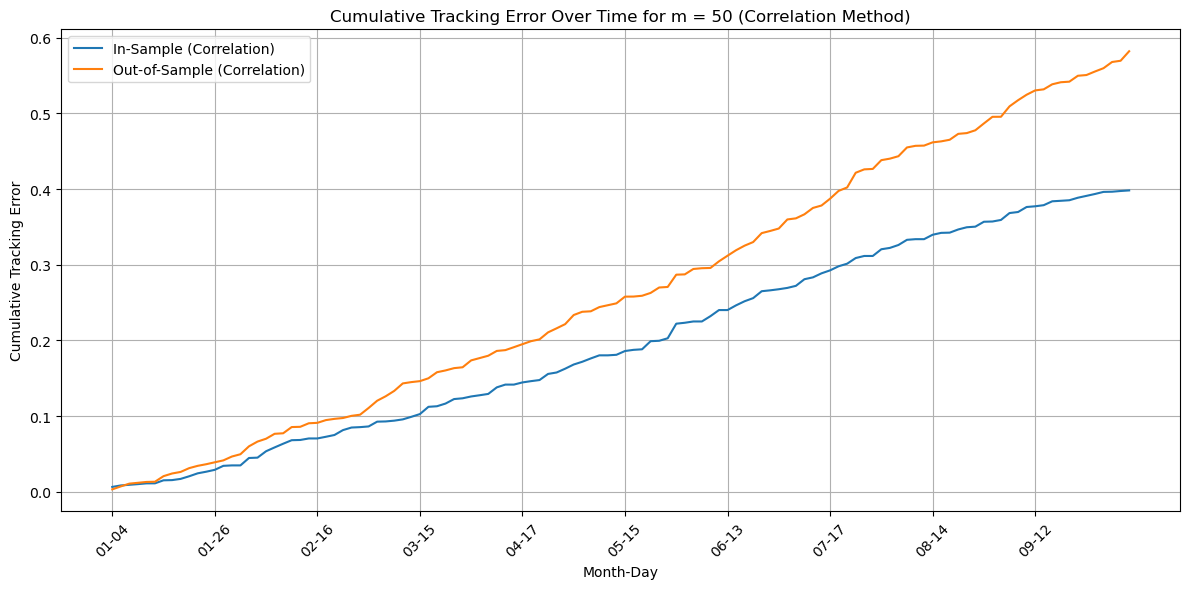

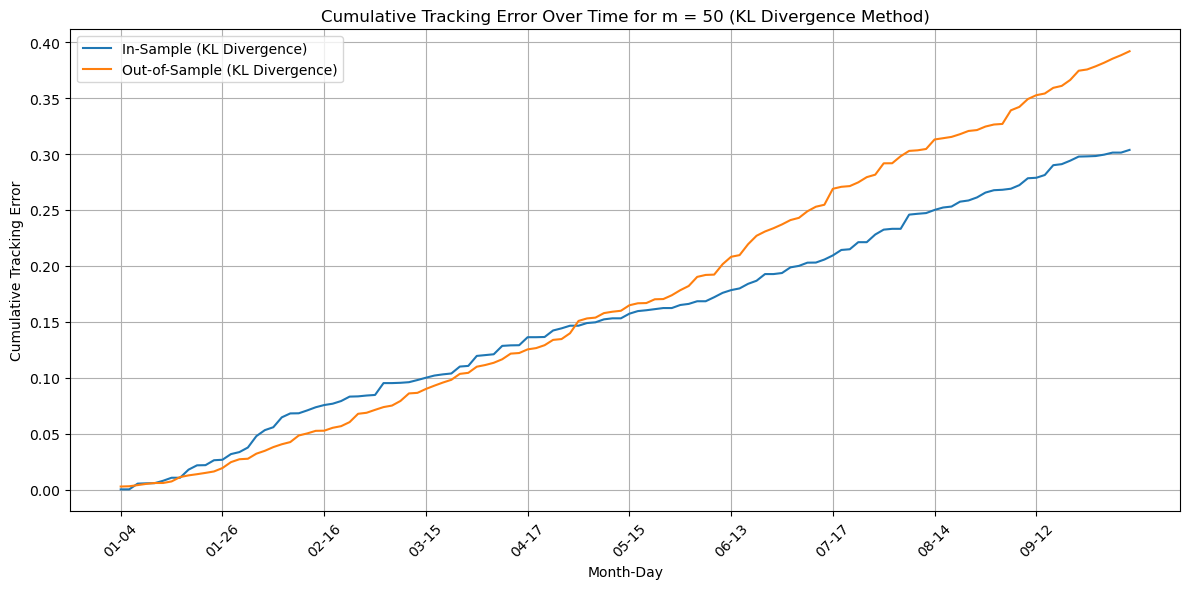

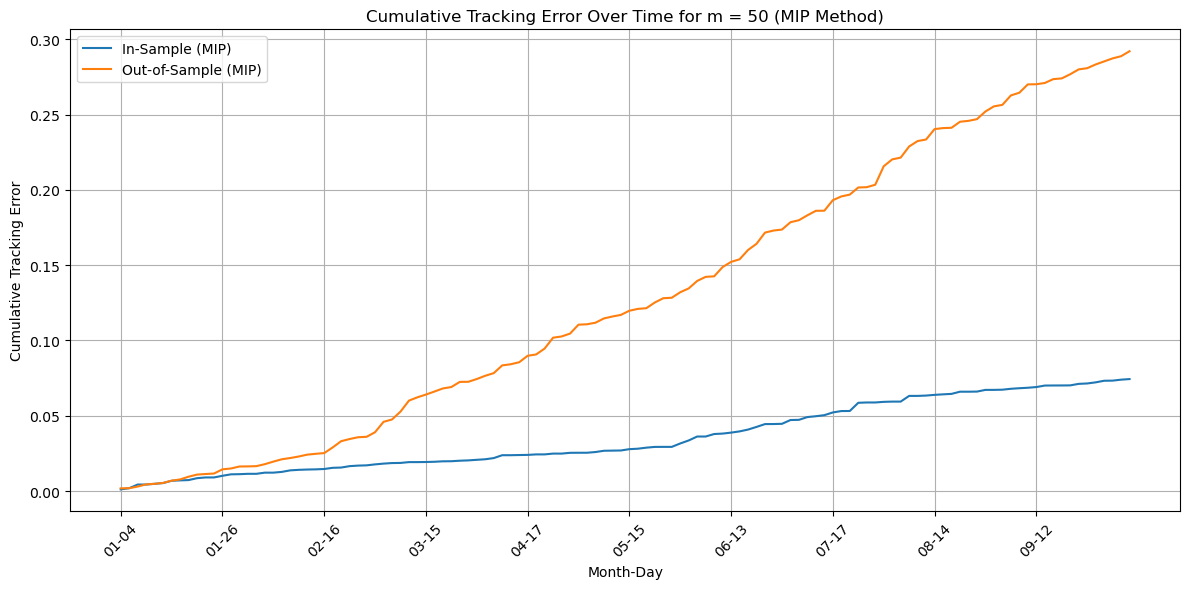

In [32]:
# Select m values for which to plot cumulative tracking errors\
# For Correlation method
m_selected_for_plot_corr = 40  
# For KL Divergence method
m_selected_for_plot_kld = 40 
# For MIP method
m_selected_for_plot_mip = 30   

# Function to plot cumulative tracking error over time for a given method and m
# suggestion from TA. The plots are pretty cool!
def plot_cumulative_tracking_error_over_time(results, method_name, m_selected_for_plot):
    # Find the result corresponding to the selected m
    result = next((res for res in results if res['m'] == m_selected_for_plot), None)
    if result is None:
        print(f"No results found for m = {m_selected_for_plot} in {method_name} method.")
        return
    
    selected_stocks = result['selected_stocks']
    optimal_weights = result.get('optimal_weights', None)
    weights = result.get('weights', None)
    
    if optimal_weights is not None:
        # LP methods (Correlation and KLD)
        # In-Sample (2023)
        returns_2023_selected = returns_2023[selected_stocks].dropna()
        index_returns_2023_selected = index_returns_2023.loc[returns_2023_selected.index]
        portfolio_returns_2023 = returns_2023_selected.values @ np.array(optimal_weights)
        tracking_error_2023 = np.abs(portfolio_returns_2023 - index_returns_2023_selected.values)
        cumulative_tracking_error_2023 = np.cumsum(tracking_error_2023)
        
        # Out-of-Sample (2024)
        returns_2024_selected = returns_2024[selected_stocks].dropna()
        index_returns_2024_selected = index_returns_2024.loc[returns_2024_selected.index]
        portfolio_returns_2024 = returns_2024_selected.values @ np.array(optimal_weights)
        tracking_error_2024 = np.abs(portfolio_returns_2024 - index_returns_2024_selected.values)
        cumulative_tracking_error_2024 = np.cumsum(tracking_error_2024)
    elif weights is not None:
        # MIP method
        # In-Sample (2023)
        returns_2023_selected = returns_2023[selected_stocks].dropna()
        index_returns_2023_selected = index_returns_2023.loc[returns_2023_selected.index]
        portfolio_returns_2023 = returns_2023_selected @ pd.Series(weights)
        tracking_error_2023 = np.abs(portfolio_returns_2023 - index_returns_2023_selected)
        cumulative_tracking_error_2023 = tracking_error_2023.cumsum()
        
        # Out-of-Sample (2024)
        returns_2024_selected = returns_2024[selected_stocks].dropna()
        index_returns_2024_selected = index_returns_2024.loc[returns_2024_selected.index]
        missing_stocks_2024 = set(selected_stocks) - set(returns_2024_selected.columns)
        if missing_stocks_2024:
            for stock in missing_stocks_2024:
                del weights[stock]
            selected_stocks = [stock for stock in selected_stocks if stock in returns_2024_selected.columns]
            total_weight = sum(weights.values())
            weights = {stock: weight / total_weight for stock, weight in weights.items()}
        
        portfolio_returns_2024 = returns_2024_selected @ pd.Series(weights)
        tracking_error_2024 = np.abs(portfolio_returns_2024 - index_returns_2024_selected)
        cumulative_tracking_error_2024 = tracking_error_2024.cumsum()
    else:
        print(f"No weights found for m = {m_selected_for_plot} in {method_name} method.")
        return

    # Align the in-sample and out-of-sample errors to start at the same point
    # Extract month and day from the date indices, ignoring the year
    dates_2023 = pd.to_datetime(returns_2023_selected.index)
    dates_2023_md = dates_2023.strftime('%m-%d')
    
    dates_2024 = pd.to_datetime(returns_2024_selected.index)
    dates_2024_md = dates_2024.strftime('%m-%d')
    
    # Create a common x-axis based on month-day
    # Find the common date range
    common_dates = sorted(set(dates_2023_md).intersection(set(dates_2024_md)))
    
    # Filter cumulative tracking errors to include only common dates
    common_indices_2023 = dates_2023_md.isin(common_dates)
    cumulative_tracking_error_2023_common = cumulative_tracking_error_2023[common_indices_2023]
    dates_2023_common = dates_2023_md[common_indices_2023]
    
    common_indices_2024 = dates_2024_md.isin(common_dates)
    cumulative_tracking_error_2024_common = cumulative_tracking_error_2024[common_indices_2024]
    dates_2024_common = dates_2024_md[common_indices_2024]
    
    # Since dates are the same, we can use the common_dates as x-axis
    # Reset index for plotting
    x_axis = np.arange(len(common_dates))
    
    # Plot cumulative tracking error over time
    plt.figure(figsize=(12, 6))
    # In-Sample
    plt.plot(x_axis, cumulative_tracking_error_2023_common, label=f'In-Sample ({method_name})')
    # Out-of-Sample
    plt.plot(x_axis, cumulative_tracking_error_2024_common, label=f'Out-of-Sample ({method_name})')
    
    plt.xlabel('Month-Day')
    plt.ylabel('Cumulative Tracking Error')
    plt.title(f'Cumulative Tracking Error Over Time for m = {m_selected_for_plot} ({method_name} Method)')
    plt.legend()
    plt.grid(True)
    
    # Set x-ticks to show month-day labels at regular intervals
    # Show 10 ticks at most
    tick_spacing = max(1, len(x_axis) // 10)  
    plt.xticks(x_axis[::tick_spacing], common_dates[::tick_spacing], rotation=45)
    plt.tight_layout()

# Plot cumulative tracking error for Correlation method
plot_cumulative_tracking_error_over_time(results_corr, 'Correlation', m_selected_for_plot_corr)

# Plot cumulative tracking error for KL Divergence method
plot_cumulative_tracking_error_over_time(results_kld, 'KL Divergence', m_selected_for_plot_kld)

# Plot cumulative tracking error for MIP method
plot_cumulative_tracking_error_over_time(results_mip, 'MIP', m_selected_for_plot_mip)
